<a href="https://colab.research.google.com/github/MizeroR/realwaste-classifier/blob/main/notebooks/Summative_assignment_MLOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
import shutil
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: False


In [8]:
CLASS_LABELS = [
    'Cardboard',
    'Food Organics',
    'Glass',
    'Metal',
    'Miscellaneous Trash',
    'Paper',
    'Plastic',
    'Textile Trash',
    'Vegetation'
]

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = len(CLASS_LABELS)
DATASET_SIZE = 4752

In [15]:
print("DOWNLOADING REALWASTE DATASET")

DATASET_URL = "https://archive.ics.uci.edu/static/public/908/realwaste.zip"
DATASET_ZIP = "realwaste.zip"
EXTRACT_DIR = "realwaste_data"

print(f"\nDownloading dataset from: {DATASET_URL}")

!wget -q --show-progress {DATASET_URL} -O {DATASET_ZIP}

print("\n Download complete!")

DOWNLOADING REALWASTE DATASET

realwaste.zip           [           <=>      ] 656.65M  60.2MB/s    in 12s     

 Download complete!


In [16]:
print(f"\nExtracting dataset to: {EXTRACT_DIR}/")
!unzip -o -q {DATASET_ZIP} -d {EXTRACT_DIR}

print("Extraction complete!")

print("\nInspecting dataset structure...")
!ls -la {EXTRACT_DIR}

def find_data_root(extract_dir):
    """Find the directory containing the actual image class folders"""
    for root, dirs, files in os.walk(extract_dir):
        dir_names = [d.lower() for d in dirs]
        if any(cls.lower().replace(' ', '_') in dir_names or
               cls.lower().replace(' ', '-') in dir_names or
               cls.lower().replace(' ', '') in dir_names
               for cls in CLASS_LABELS):
            return root
    return extract_dir

DATA_ROOT = find_data_root(EXTRACT_DIR)
print(f"\nData root directory: {DATA_ROOT}")
print("\nDirectories found:")
!ls -la {DATA_ROOT}


Extracting dataset to: realwaste_data/
Extraction complete!

Inspecting dataset structure...
total 12
drwxr-xr-x 3 root root 4096 Nov 26 10:18 .
drwxr-xr-x 1 root root 4096 Nov 26 10:18 ..
drwxr-xr-x 3 root root 4096 Dec  1  2023 realwaste-main

Data root directory: realwaste_data/realwaste-main/RealWaste

Directories found:
total 236
drwxr-xr-x 11 root root  4096 Dec  1  2023  .
drwxr-xr-x  3 root root  4096 Dec  1  2023  ..
drwxr-xr-x  2 root root 20480 Dec  1  2023  Cardboard
drwxr-xr-x  2 root root 24576 Dec  1  2023 'Food Organics'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Glass
drwxr-xr-x  2 root root 36864 Dec  1  2023  Metal
drwxr-xr-x  2 root root 32768 Dec  1  2023 'Miscellaneous Trash'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Paper
drwxr-xr-x  2 root root 36864 Dec  1  2023  Plastic
drwxr-xr-x  2 root root 20480 Dec  1  2023 'Textile Trash'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Vegetation


In [17]:
DATA_DIR = DATA_ROOT

print(f"\nDataset Configuration:")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Total Instances: {DATASET_SIZE}")
print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Classes: {', '.join(CLASS_LABELS)}")
print(f"Data Directory: {DATA_DIR}")


Dataset Configuration:
Number of Classes: 9
Total Instances: 4752
Image Size: 224x224
Classes: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation
Data Directory: realwaste_data/realwaste-main/RealWaste


In [18]:
def load_dataset_info(data_dir):
    """
    Load and explore dataset structure
    Handles different possible naming conventions
    """
    class_counts = {}
    all_files = []

    # Try to find directories for each class (handling different naming conventions)
    for class_name in CLASS_LABELS:
        # different variations of class names
        possible_names = [
            class_name,  # Original: "Food Organics"
            class_name.replace(' ', '_'),  # With underscore: "Food_Organics"
            class_name.replace(' ', '-'),  # With dash: "Food-Organics"
            class_name.replace(' ', ''),   # No space: "FoodOrganics"
            class_name.lower(),  # Lowercase: "food organics"
            class_name.lower().replace(' ', '_'),  # Lowercase underscore: "food_organics"
            class_name.lower().replace(' ', '-'),  # Lowercase dash: "food-organics"
            class_name.lower().replace(' ', ''),   # Lowercase no space: "foodorganics"
        ]

        found = False
        for name_variant in possible_names:
            class_path = Path(data_dir) / name_variant
            if class_path.exists() and class_path.is_dir():
                # Find all image files
                files = (list(class_path.glob('*.jpg')) +
                        list(class_path.glob('*.jpeg')) +
                        list(class_path.glob('*.png')) +
                        list(class_path.glob('*.JPG')) +
                        list(class_path.glob('*.JPEG')) +
                        list(class_path.glob('*.PNG')))

                class_counts[class_name] = len(files)
                all_files.extend([(str(f), class_name) for f in files])
                print(f"✓ Found {len(files)} images for '{class_name}' in directory '{name_variant}'")
                found = True
                break

        if not found:
            class_counts[class_name] = 0
            print(f"⚠️ Warning: No directory found for '{class_name}'")

    return class_counts, all_files

# Load dataset information
class_counts, file_list = load_dataset_info(DATA_DIR)

df = pd.DataFrame(file_list, columns=['filepath', 'class'])
print(f"\nDataset loaded: {len(df)} images")
print("\nClass Distribution:")
print(df['class'].value_counts())

plt.figure(figsize=(12, 6))
df['class'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('RealWaste Dataset: Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Waste Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nClass Balance Analysis:")
class_percentages = df['class'].value_counts(normalize=True) * 100
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")

imbalance_ratio = class_percentages.max() / class_percentages.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 2:
    print("Significant class imbalance detected - consider using class weights")

✓ Found 461 images for 'Cardboard' in directory 'Cardboard'
✓ Found 411 images for 'Food Organics' in directory 'Food Organics'
✓ Found 420 images for 'Glass' in directory 'Glass'
✓ Found 790 images for 'Metal' in directory 'Metal'
✓ Found 495 images for 'Miscellaneous Trash' in directory 'Miscellaneous Trash'
✓ Found 500 images for 'Paper' in directory 'Paper'
✓ Found 921 images for 'Plastic' in directory 'Plastic'
✓ Found 318 images for 'Textile Trash' in directory 'Textile Trash'
✓ Found 436 images for 'Vegetation' in directory 'Vegetation'

Dataset loaded: 4752 images

Class Distribution:
class
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64



Class Balance Analysis:
Plastic: 19.38%
Metal: 16.62%
Paper: 10.52%
Miscellaneous Trash: 10.42%
Cardboard: 9.70%
Vegetation: 9.18%
Glass: 8.84%
Food Organics: 8.65%
Textile Trash: 6.69%

Imbalance Ratio: 2.90x
Significant class imbalance detected - consider using class weights


In [19]:
# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print(f"\nData Split:")
print(f"Training: {len(train_df)} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"Testing: {len(test_df)} images ({len(test_df)/len(df)*100:.1f}%)")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nData generators created successfully")


Data Split:
Training: 3326 images (70.0%)
Validation: 713 images (15.0%)
Testing: 713 images (15.0%)
Found 3326 validated image filenames belonging to 9 classes.
Found 713 validated image filenames belonging to 9 classes.
Found 713 validated image filenames belonging to 9 classes.

Data generators created successfully


In [20]:
label_to_index = train_generator.class_indices

df['label_id'] = df['class'].map(label_to_index)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_id']),
    y=df['label_id']
)

class_weights = {i: float(w) for i, w in enumerate(class_weights_array)}

print("FINAL Class Weights:", class_weights)


FINAL Class Weights: {0: 1.1453362255965294, 1: 1.2846715328467153, 2: 1.2571428571428571, 3: 0.6683544303797468, 4: 1.0666666666666667, 5: 1.056, 6: 0.5732899022801303, 7: 1.6603773584905661, 8: 1.2110091743119267}


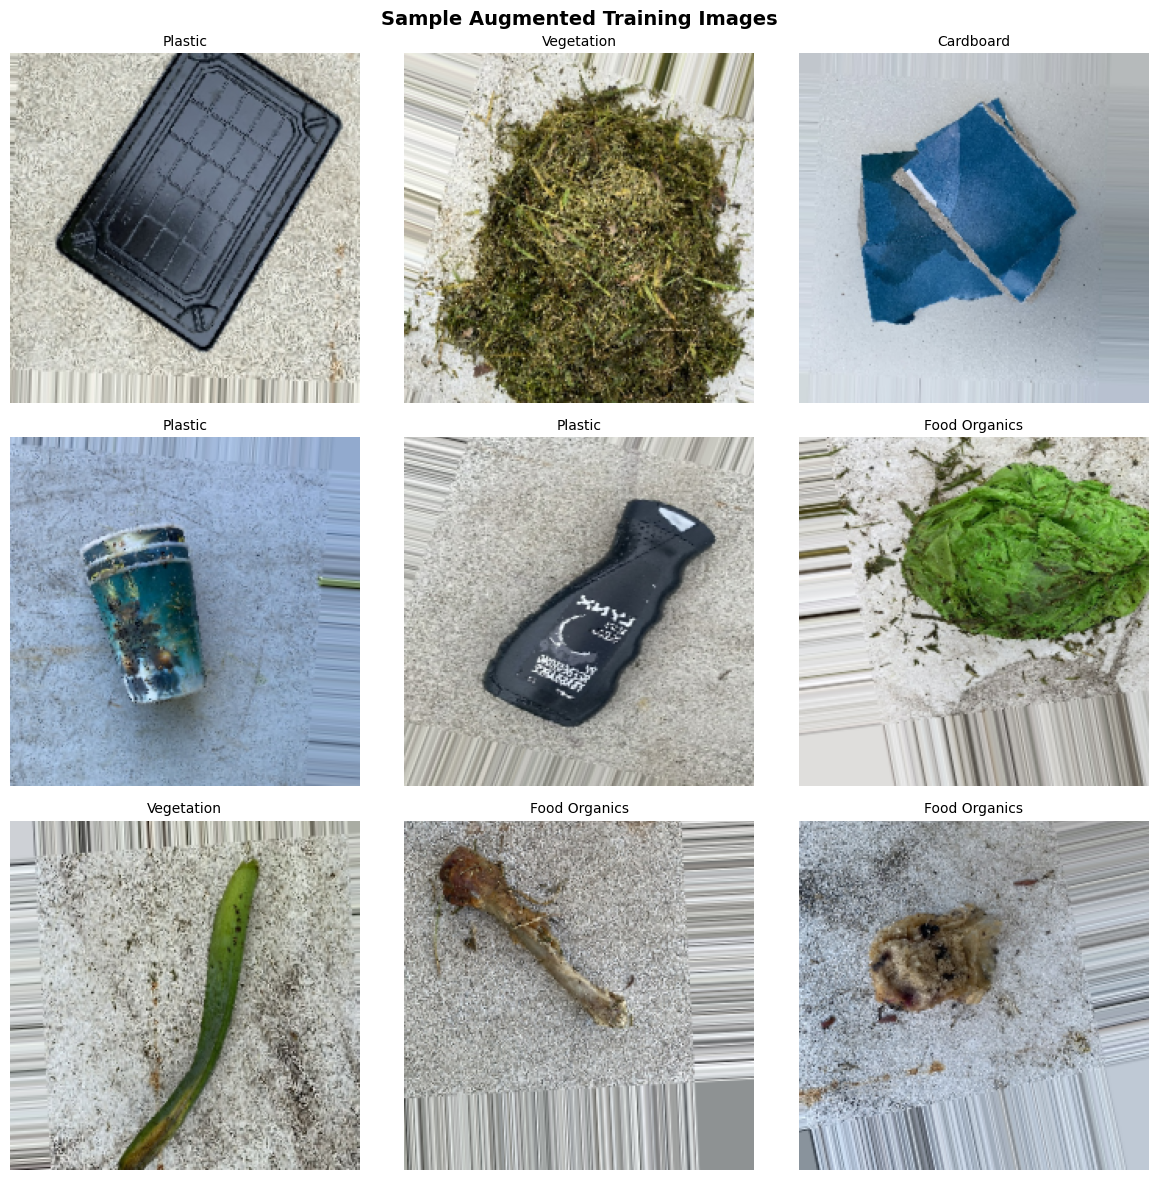

In [21]:
# Visualize sample augmented images
def visualize_augmentation(generator, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    batch = next(generator)
    images, labels = batch[0], batch[1]

    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i])
        class_idx = np.argmax(labels[i])
        axes[i].set_title(CLASS_LABELS[class_idx], fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Sample Augmented Training Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)


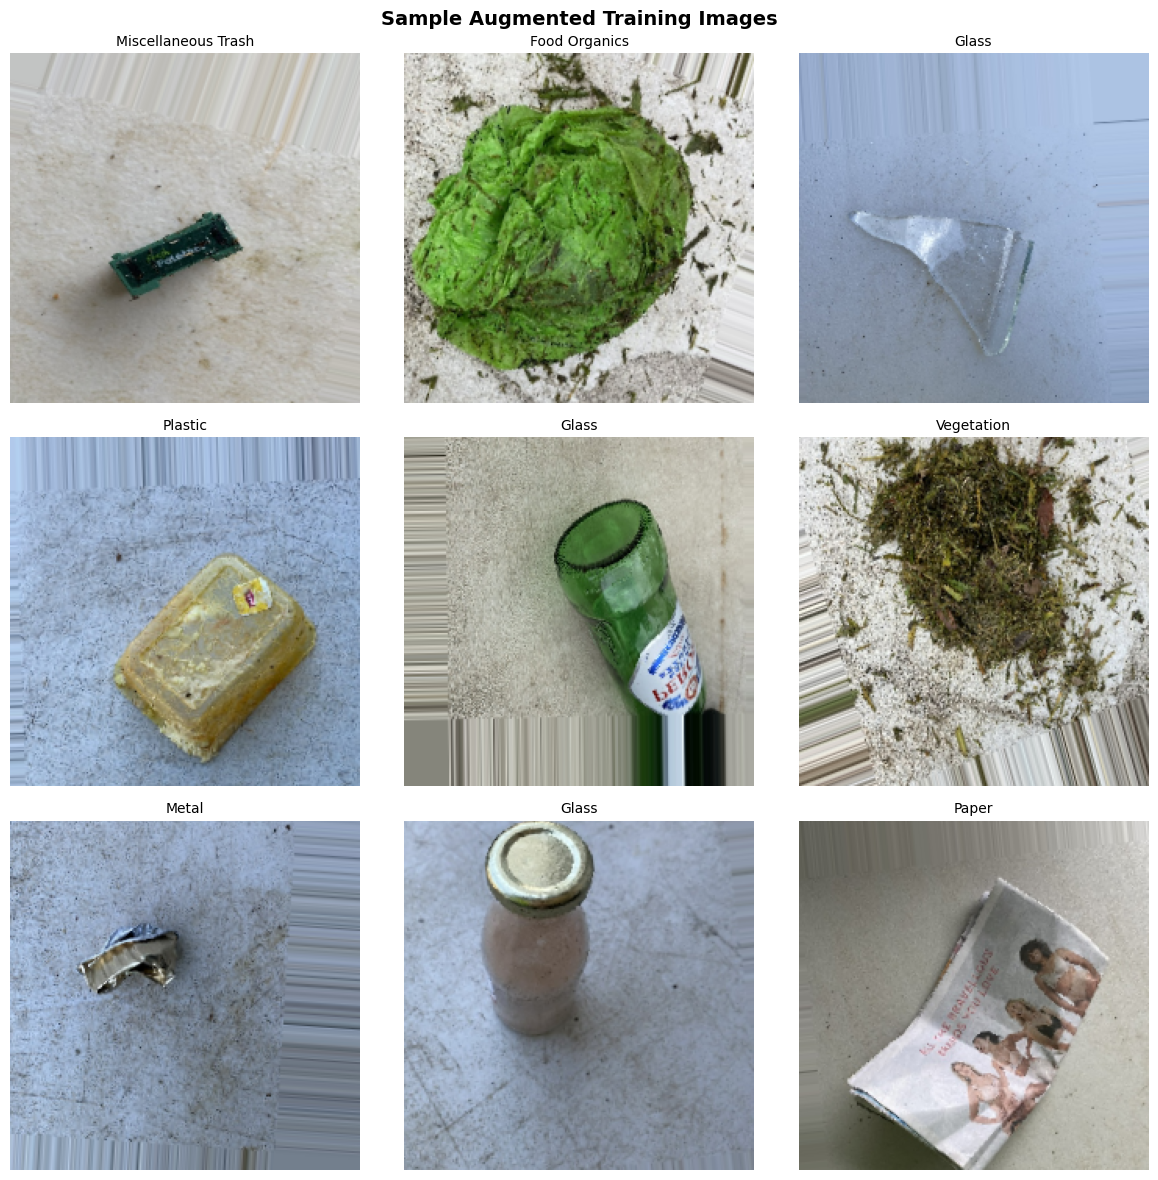

In [22]:
# Visualize sample augmented images
def visualize_augmentation(generator, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    batch = next(generator)
    images, labels = batch[0], batch[1]

    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i])
        class_idx = np.argmax(labels[i])
        axes[i].set_title(CLASS_LABELS[class_idx], fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Sample Augmented Training Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)


In [ ]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Experiment 1: MobileNetV2 with Fine-tuning (Functional API)

In [ ]:
def create_mobilenet_model():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    base = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model, base

mobilenet_model, mobilenet_base = create_mobilenet_model()

# Phase 1
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

history_mobilenet_phase1 = mobilenet_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    class_weight=class_weights
)

# Phase 2
mobilenet_base.trainable = True
for layer in mobilenet_base.layers[:-20]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

history_mobilenet_phase2 = mobilenet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights
)


I0000 00:00:1764141586.218244      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764141586.218829      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1764141594.675343     140 service.cc:148] XLA service 0x7b51780034f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764141594.676175     140 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764141594.676194     140 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764141595.601991     140 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/104 ━━━━━━━━━━━━━━━━━━━━ 19:08 11s/step - accuracy: 0.0938 - f1_m: 0.0909 - loss: 3.2898 - precision_m: 0.1667 - recall_m: 0.0625

I0000 00:00:1764141600.471896     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 65s 525ms/step - accuracy: 0.4366 - f1_m: 0.4168 - loss: 1.8401 - precision_m: 0.4928 - recall_m: 0.3668 - val_accuracy: 0.6592 - val_f1_m: 0.6208 - val_loss: 0.9417 - val_precision_m: 0.7363 - val_recall_m: 0.5402
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.6737 - f1_m: 0.6740 - loss: 0.9409 - precision_m: 0.7291 - recall_m: 0.6285 - val_accuracy: 0.7041 - val_f1_m: 0.6874 - val_loss: 0.8930 - val_precision_m: 0.7308 - val_recall_m: 0.6505
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.7325 - f1_m: 0.7317 - loss: 0.7536 - precision_m: 0.7796 - recall_m: 0.6906 - val_accuracy: 0.7349 - val_f1_m: 0.7317 - val_loss: 0.8073 - val_precision_m: 0.7686 - val_recall_m: 0.6988
Epoch 4/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.7509 - f1_m: 0.7553 - loss: 0.6744 - precision_m: 0.7937 - recall_m: 0.7215 - val_accuracy: 0.7153 - val_f1_m: 0.7092 - val_loss: 0.8191 - val_precision_m: 0.7437 - val_recall_m

# Experiment 2: EfficientNetB0 with Fine-tuning (Functional API)

In [ ]:
def create_efficientnet_model():
    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base.trainable = False

    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model, base

efficientnet_model, efficientnet_base = create_efficientnet_model()

# Phase 1
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

history_eff_phase1 = efficientnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights
)

# Phase 2
efficientnet_base.trainable = True
for layer in efficientnet_base.layers[:-50]:
    layer.trainable = False

efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

history_eff_phase2 = efficientnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 586ms/step - accuracy: 0.1076 - f1_m: 0.0270 - loss: 2.7226 - precision_m: 0.1505 - recall_m: 0.0153 - val_accuracy: 0.1669 - val_f1_m: 0.0000e+00 - val_loss: 2.1927 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 411ms/step - accuracy: 0.1071 - f1_m: 0.0026 - loss: 2.3712 - precision_m: 0.0375 - recall_m: 0.0013 - val_accuracy: 0.1052 - val_f1_m: 0.0000e+00 - val_loss: 2.1970 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 409ms/step - accuracy: 0.1121 - f1_m: 3.0224e-04 - loss: 2.2496 - precision_m: 0.0050 - recall_m: 1.5584e-04 - val_accuracy: 0.0968 - val_f1_m: 0.0000e+00 - val_loss: 2.1986 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 412ms/step - accuracy: 0.1194 - f1_m: 0.0023 - loss: 2.2262 - precision_m: 0.0374 - recall_m: 0.

E0000 00:00:1764144675.009110     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764144675.149481     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 93/104 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.1784 - f1_m: 0.0000e+00 - loss: 2.1959 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

E0000 00:00:1764144724.403764     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764144724.544039     139 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


104/104 ━━━━━━━━━━━━━━━━━━━━ 94s 622ms/step - accuracy: 0.1780 - f1_m: 0.0000e+00 - loss: 2.1965 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.1935 - val_f1_m: 0.0000e+00 - val_loss: 2.1956 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 409ms/step - accuracy: 0.1830 - f1_m: 0.0013 - loss: 2.1982 - precision_m: 0.0211 - recall_m: 6.5957e-04 - val_accuracy: 0.1935 - val_f1_m: 0.0000e+00 - val_loss: 2.1956 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - accuracy: 0.1866 - f1_m: 1.6704e-05 - loss: 2.1782 - precision_m: 2.7561e-04 - recall_m: 8.6129e-06 - val_accuracy: 0.1935 - val_f1_m: 0.0000e+00 - val_loss: 2.1957 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 406ms/step - accuracy: 0.1995 - f1_m: 0.0000e+00 - loss: 2.1986 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.1935 - 

In [ ]:
def merge_histories(h1, h2):
    merged = {}
    for key in h1.history.keys():
        merged[key] = h1.history[key] + h2.history[key]
    return merged


In [ ]:
mobilenet_history = merge_histories(history_mobilenet_phase1, history_mobilenet_phase2)

In [ ]:
efficientnet_history = merge_histories(history_eff_phase1, history_eff_phase2)

In [ ]:
def plot_full_history(history, title="Model Training Metrics"):
    plt.figure(figsize=(16, 12))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(history['accuracy'], label='Train Acc')
    plt.plot(history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Precision
    plt.subplot(3, 2, 3)
    plt.plot(history['precision_m'], label='Train Precision')
    plt.plot(history['val_precision_m'], label='Val Precision')
    plt.title('Precision')
    plt.legend()

    # Recall
    plt.subplot(3, 2, 4)
    plt.plot(history['recall_m'], label='Train Recall')
    plt.plot(history['val_recall_m'], label='Val Recall')
    plt.title('Recall')
    plt.legend()

    # F1-score
    plt.subplot(3, 2, 5)
    plt.plot(history['f1_m'], label='Train F1')
    plt.plot(history['val_f1_m'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
plot_full_history(mobilenet_history, title="MobileNetV2 Training Curves")

In [ ]:
plot_full_history(efficientnet_history, title="EfficientNetB0 Training Curves")

In [ ]:
def get_predictions(model, generator):
    y_true = generator.classes
    y_pred_prob = model.predict(generator)
    y_pred = np.argmax(y_pred_prob, axis=1)
    return y_true, y_pred

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
def print_classification_report(y_true, y_pred, class_names):
    print(classification_report(y_true, y_pred, target_names=class_names))


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step


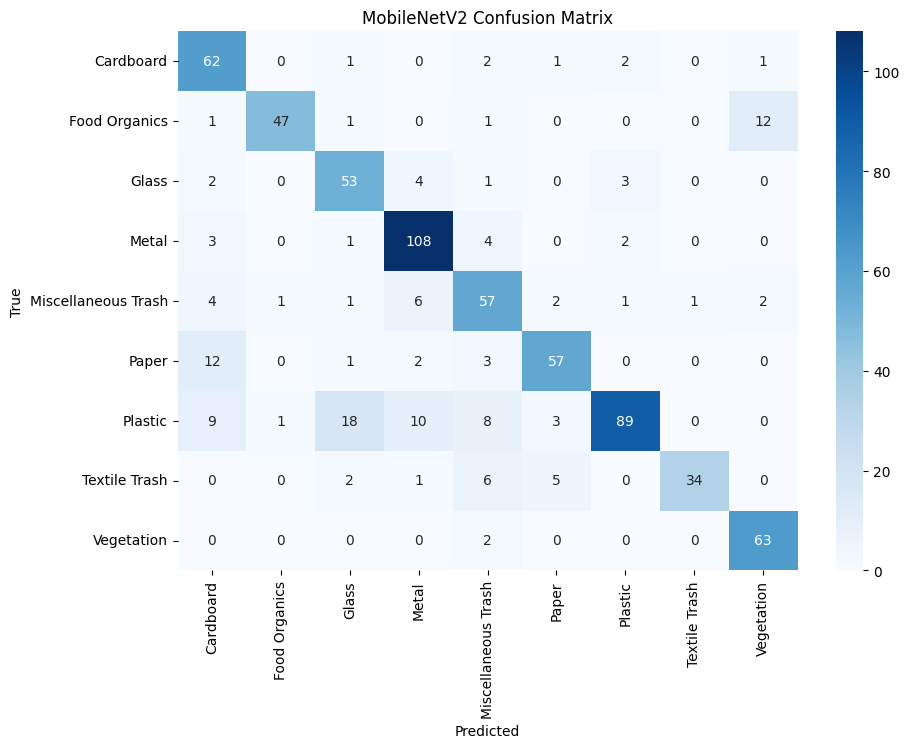

                     precision    recall  f1-score   support

          Cardboard       0.67      0.90      0.77        69
      Food Organics       0.96      0.76      0.85        62
              Glass       0.68      0.84      0.75        63
              Metal       0.82      0.92      0.87       118
Miscellaneous Trash       0.68      0.76      0.72        75
              Paper       0.84      0.76      0.80        75
            Plastic       0.92      0.64      0.76       138
      Textile Trash       0.97      0.71      0.82        48
         Vegetation       0.81      0.97      0.88        65

           accuracy                           0.80       713
          macro avg       0.82      0.81      0.80       713
       weighted avg       0.82      0.80      0.80       713



In [ ]:
mobilenet_y_true, mobilenet_y_pred = get_predictions(mobilenet_model, test_generator)

plot_confusion_matrix(
    mobilenet_y_true,
    mobilenet_y_pred,
    class_names=CLASS_LABELS,
    title="MobileNetV2 Confusion Matrix"
)

print_classification_report(
    mobilenet_y_true,
    mobilenet_y_pred,
    class_names=CLASS_LABELS
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 342ms/step


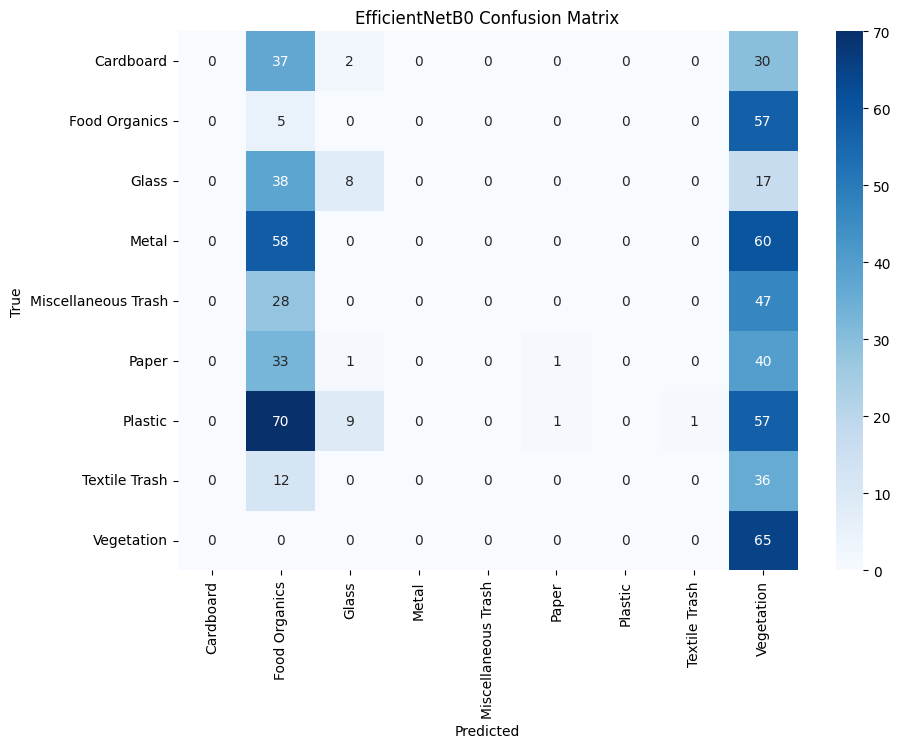

                     precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00        69
      Food Organics       0.02      0.08      0.03        62
              Glass       0.40      0.13      0.19        63
              Metal       0.00      0.00      0.00       118
Miscellaneous Trash       0.00      0.00      0.00        75
              Paper       0.50      0.01      0.03        75
            Plastic       0.00      0.00      0.00       138
      Textile Trash       0.00      0.00      0.00        48
         Vegetation       0.16      1.00      0.27        65

           accuracy                           0.11       713
          macro avg       0.12      0.14      0.06       713
       weighted avg       0.10      0.11      0.05       713



In [ ]:
eff_y_true, eff_y_pred = get_predictions(efficientnet_model, test_generator)

plot_confusion_matrix(
    eff_y_true,
    eff_y_pred,
    class_names=CLASS_LABELS,
    title="EfficientNetB0 Confusion Matrix"
)

print_classification_report(
    eff_y_true,
    eff_y_pred,
    class_names=CLASS_LABELS
)

In [ ]:
# Evaluate MobileNetV2 on test set
mobilenet_eval = mobilenet_model.evaluate(test_generator)
mobilenet_metrics = {
    "accuracy": mobilenet_eval[1],
    "precision": mobilenet_eval[2],
    "recall": mobilenet_eval[3],
    "f1": mobilenet_eval[4]
}
print("\nMobileNetV2 Test Metrics:", mobilenet_metrics)

# Evaluate EfficientNetB0 the same way if not already done
efficientnet_eval = efficientnet_model.evaluate(test_generator)
efficientnet_metrics = {
    "accuracy": efficientnet_eval[1],
    "precision": efficientnet_eval[2],
    "recall": efficientnet_eval[3],
    "f1": efficientnet_eval[4]
}
print("\nEfficientNetB0 Test Metrics:", efficientnet_metrics)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7919 - f1_m: 0.7980 - loss: 0.9180 - precision_m: 0.8073 - recall_m: 0.7890

MobileNetV2 Test Metrics: {'accuracy': 0.799439013004303, 'precision': 0.811489999294281, 'recall': 0.7919686436653137, 'f1': 0.8015141487121582}
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.1059 - f1_m: 0.1205 - loss: 2.2201 - precision_m: 0.4425 - recall_m: 0.0707

EfficientNetB0 Test Metrics: {'accuracy': 0.11079943925142288, 'precision': 0.5376811027526855, 'recall': 0.07955918461084366, 'f1': 0.13668197393417358}


In [ ]:
# Store all metrics for each model
models_dict = {
    "MobileNetV2": {
        "model": mobilenet_model,
        "accuracy": mobilenet_metrics["accuracy"],
        "precision": mobilenet_metrics["precision"],
        "recall": mobilenet_metrics["recall"],
        "f1": mobilenet_metrics["f1"]
    },
    "EfficientNetB0": {
        "model": efficientnet_model,
        "accuracy": efficientnet_metrics["accuracy"],
        "precision": efficientnet_metrics["precision"],
        "recall": efficientnet_metrics["recall"],
        "f1": efficientnet_metrics["f1"]
    }
}

In [ ]:
# Use average of all 4 metrics to determine best model
best_model_name = max(
    models_dict,
    key=lambda m: (
        models_dict[m]["accuracy"] +
        models_dict[m]["precision"] +
        models_dict[m]["recall"] +
        models_dict[m]["f1"]
    ) / 4
)

best_model = models_dict[best_model_name]["model"]
save_path = f"{best_model_name}_best_model.h5"
best_model.save(save_path)

print(f"\nBest Model = {best_model_name}")
print(f"Saved as: {save_path}")
print(f"Metrics: {models_dict[best_model_name]}")



Best Model = MobileNetV2
Saved as: MobileNetV2_best_model.h5
Metrics: {'model': <Functional name=functional, built=True>, 'accuracy': 0.799439013004303, 'precision': 0.811489999294281, 'recall': 0.7919686436653137, 'f1': 0.8015141487121582}


In [38]:
UPLOAD_DIR = "data"          # User drops new images here
RETRAIN_DIR = "retrain_data/"   # Folder to save for retraining
os.makedirs(UPLOAD_DIR, exist_ok=True)
os.makedirs(RETRAIN_DIR, exist_ok=True)

uploaded_files = [f for f in os.listdir(UPLOAD_DIR) if not f.startswith('.')]
if not uploaded_files:
    print("No new images found in the upload folder. Skipping retraining.")
else:
    # Move uploaded files to retraining folder, skip hidden files
    for filename in uploaded_files:
        dest_path = os.path.join(RETRAIN_DIR, filename)
        if os.path.exists(dest_path):
            os.remove(dest_path)  # overwrite if exists
        shutil.move(os.path.join(UPLOAD_DIR, filename), dest_path)
    print(f"{len(uploaded_files)} images moved to {RETRAIN_DIR}")

    # Create metadata CSV
    retrain_files = []
    for f in os.listdir(RETRAIN_DIR):
        if f.startswith('.'):
            continue  # skip hidden files
        class_name = f.split("_")[0].split(".")[0]  # remove extension for class name
        if class_name not in CLASS_LABELS:
            print(f"Class '{f}' not in defined CLASS_LABELS, skipping")
            continue
        retrain_files.append((os.path.join(RETRAIN_DIR, f), class_name))

    retrain_df = pd.DataFrame(retrain_files, columns=['filepath', 'class'])
    retrain_df.to_csv("retrain_metadata.csv", index=False)
    print(f"Retraining metadata saved ({len(retrain_df)} images)")

    if len(retrain_df) == 0:
        print("No valid images to retrain. Exiting.")
    else:
        # Data preprocessing
        retrain_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        retrain_generator = retrain_datagen.flow_from_dataframe(
            retrain_df,
            x_col='filepath',
            y_col='class',
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )

        # Load best model and compile
        best_model_path = "MobileNetV2_best_model.h5"  # or EfficientNetB0_best_model.h5
        retrain_model = load_model(best_model_path)

        retrain_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision_m'),
                tf.keras.metrics.Recall(name='recall_m')
            ]
        )

        # Retrain model
        history_retrain = retrain_model.fit(
            retrain_generator,
            epochs=5,  # minimal epochs for quick incremental retraining
            class_weight=class_weights,  # recompute if new data is imbalanced
            verbose=1
        )

        # Save retrained model
        retrain_model.save("best_model_retrained.h5")
        print("Model retrained and saved as best_model_retrained.h5")


27 images moved to retrain_data/
Retraining metadata saved (27 images)
Found 27 validated image filenames belonging to 9 classes.


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.8889 - loss: 0.4060 - precision_m: 0.8889 - recall_m: 0.8889
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9630 - loss: 0.0524 - precision_m: 0.9630 - recall_m: 0.9630
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0473 - precision_m: 1.0000 - recall_m: 1.0000
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0195 - precision_m: 1.0000 - recall_m: 1.0000
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0167 - precision_m: 1.0000 - recall_m: 1.0000


Model retrained and saved as best_model_retrained.h5
